In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from logger import logger
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common_functions import NPCL, common
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rcParams['figure.figsize'] = (20, 5)
npcl_obj = NPCL()
common_obj  = common()

In [2]:
import os
from logger import logger
import joblib
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
class testing:
    
    def add_lags(self, dff, target_col, large_data= False):
        try:
            # target_map = dff['consumed_unit'].to_dict()
            target_map = dff[target_col].to_dict()

            # 1 Hour, 2 Hours, 6 Hours
            dff['lag1_hour']   =  (dff.index - pd.Timedelta('1 hour')).map(target_map)
            dff['lag2_hours']  =  (dff.index - pd.Timedelta('2 hours')).map(target_map)
            dff['lag3_hours']  =  (dff.index - pd.Timedelta('3 hours')).map(target_map)
            # dff['lag6_hours']  =  (dff.index - pd.Timedelta('6 hours')).map(target_map)
            # dff['lag12_hours'] =  (dff.index - pd.Timedelta('12 hours')).map(target_map)
            dff['lag1_day']    =  (dff.index - pd.Timedelta('1 day')).map(target_map)
            # dff['lag2_days']   =  (dff.index - pd.Timedelta('2 days')).map(target_map)
            # dff['lag3_days']   =  (dff.index - pd.Timedelta('3 days')).map(target_map)
            dff['lag7_days']   =  (dff.index - pd.Timedelta('7 days')).map(target_map)

            # if large_data:
            # dff['lag_15_day'] = (dff.index - pd.Timedelta('15 days')).map(target_map)
            # dff['lag_30_day'] = (dff.index - pd.Timedelta('30 days')).map(target_map)
            # dff['lag_45_day'] = (dff.index - pd.Timedelta('45 days')).map(target_map)
                # logger.info(f" lags added for large data")
            #     return dff
            # else:
            


            logger.info(f"lags added")
            return dff
        
        except KeyError as e:
            logger.error(f"Error: {e}. 'consumed_unit' column not found in the DataFrame.",exc_info=True)
        except Exception as ex:
            logger.error(f"An unexpected error occurred: {ex}",exc_info= True)


    def create_features(self,hourly_data,lagre_data= False):
        try:
            hourly_data = hourly_data.copy()
            # Check if the index is in datetime format
            if not isinstance(hourly_data.index, pd.DatetimeIndex):
                hourly_data.index = pd.to_datetime(hourly_data.index)
            
            hourly_data['hour'] = hourly_data.index.hour
            hourly_data['day'] = hourly_data.index.day
            # hourly_data['dayofweek'] = hourly_data.index.dayofweek
            hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
            hourly_data['hour'] = hourly_data.index.hour
            hourly_data['dayofweek'] = hourly_data.index.dayofweek
            # hourly_data['dayofyear'] = hourly_data.index.dayofyear
            hourly_data['is_weekend'] = hourly_data['dayofweek'].isin([5, 6]).astype(int)
            hourly_data['holiday'] = 0
            # if lagre_data:
            # hourly_data['month'] = hourly_data.index.month
            # hourly_data['quarter'] = hourly_data.index.quarter
            # hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
            # hourly_data['year'] = hourly_data.index.year
        
            return hourly_data

        except Exception as e:
            logger.info(f"error in feature creation: {e}",exc_info= True)

    def scaling_layer(self,dataset,target_variable= "Load_kW"):
        try:
            scaler = MinMaxScaler()
            # Exclude the "Load_kW" column from features to normalize
            features_to_normalize = [col for col in dataset.columns if col != target_variable]
        
            dataset[features_to_normalize] = scaler.fit_transform(dataset[features_to_normalize])
            with open('saved_model/minmax_scaler_all_feeders.pkl', 'wb') as f:
                pickle.dump(scaler, f)
            return dataset
        
        except Exception as e:
            logger.error(f"error in scaling: {e}",exc_info= True) 

    def data_split_function(self,dataset, target_variable= "Load_kW"):
        """
            Splits the given dataset into training and testing sets, separating features and the target variable.

            Args:
                dataset (pandas.DataFrame): The dataset containing both features and the target variable.
                target_variable (str): The name of the column representing the target variable to be predicted. Default is 'Load_kW'.

            Returns:
                X_train (pandas.DataFrame): Training set features.
                X_test (pandas.DataFrame): Testing set features.
                y_train (pandas.Series): Training set target variable.
                y_test (pandas.Series): Testing set target variable.
            
            Raises:
                Exception: If there's an issue during the data split, an error message is logged.

            Example:
                >>> df = pd.DataFrame({...})
                >>> X_train, X_test, y_train, y_test = obj.data_split(df, target_variable="Load_kW")
        """
        try:
            n = len(dataset)
            train_df = dataset[0:int(n*0.9)]
            test_df = dataset[int(n*0.9):]
            train_dataset, test_dataset = train_df.copy(),test_df.copy() #,val_df.copy()
            # train_labels = train_features.pop(target_variable)
            # test_labels = test_features.pop(target_variable)
            
            # print(f"train_features shape:{train_features.shape},train_label shape: {train_labels.shape}")
            # print(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            logger.info(f"data split done")
            # logger.info(f"train_features shape:{train_features.shape} ,train_label shape: {train_labels.shape}")
            # logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            logger.info(f"train_features shape:{train_dataset.shape}")
            logger.info(f"test_features shape:{test_dataset.shape}")

            return train_dataset,test_dataset
            # return train_features,test_features,train_labels, test_labels
        
        except Exception as e:
            logger.error(f"error in split: {e}",exc_info=True)


    def model_trainer(self, train_dataset, target_variable, random_state=True, model_name=None):
        try:
            # noramlizing data
            dataset_scalled = self.scaling_layer(dataset=train_dataset)

            # Split the dataset into training and test sets using train test split function with randomizing data
            if random_state:            
                # dataset_labels = dataset_scalled.pop(target_variable)
                train_features, test_features, train_label, test_label = self.data_split(dataset_scalled)    
            
            else:    
                # Split the dataset into training and test sets using custom data split function without randomizing data
                train_features, test_features = self.data_split_function(dataset=dataset_scalled)
                train_label = train_features.pop(target_variable)
                test_label = test_features.pop(target_variable)
            
            os.makedirs('saved_model/test', exist_ok=True)
            if model_name == "RFR":
                # Step 4: Initialize the RandomForestRegressor model
                model= self.random_forest_regressor(train_features=train_features,
                                                    train_label=train_label)
                logger.info(f"model trained : RandomForestRegressor")
                self.prediction(model= model,
                            input_data= test_features,
                            scoring= True,
                            test_data= test_label)
                
                # Save the model to a file
                # joblib.dump(model, 'saved_model/RandomForestRegressor_model.pkl'


            if model_name == "XGboost":
                model = self.XGboost_model(train_features= train_features,
                                        train_label= train_label)
                logger.info(f"model trained : XGboost")
                self.prediction(model= model,
                            input_data= test_features,
                            scoring= True,
                            test_data= test_label)
                # Save the model to a file
                # joblib.dump(model, 'saved_model/XGboost_model.pkl')            
                        
            files = os.listdir("saved_model/test")
            if len(files) == 0:
                model_version = 1  # Start at version 1 if no files are present
            else:
                model_version = max([int(i.split(".")[1]) for i in files if i.split(".")[1].isdigit()]) + 1
            joblib.dump(model, f"saved_model/test/{model_name}.{model_version}.pkl")
            # model_version=max([int(i) for i in range(len(os.listdir("saved_model/test")+ [0])) ])+1
            # model.save(f"saved_model/test/{model_name}_1.{model_version}")
            return model
        except Exception as e:
            logger.error(f"error in model trainer: {e}",exc_info=True)

    def data_split(self, dataset, target_variable= "Load_kW"): 
        try:
            dataset_features = dataset.copy()
            dataset_label = dataset_features.pop(target_variable)
            # Split the dataset into training and test sets
            train_features, test_features, train_labels, test_labels= train_test_split(dataset_features, dataset_label, test_size=0.1, random_state=42)
            logger.info(f"data split done")
            logger.info(f"train_features shape:{train_features.shape} ,train_label shape: {train_labels.shape}")
            logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            return train_features, test_features, train_labels, test_labels

        except Exception as e:
            logger.error(f"error in data split: {e}",exc_info=True)  

    def random_forest_regressor(self, train_features, train_label):
        try:
            # model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tweak hyperparameters
            # model.fit(train_features,train_label)
            param_grid = {
                'n_estimators': [100, 200, 300, 500, 1000],
                'max_depth': [10, 20, 30, 50, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 5, 10],
                'max_features': ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False],
                'n_jobs': [-1]  # Use all cores for faster training
            }

            # Initialize the RandomForestRegressor model
            model = RandomForestRegressor(random_state=42)

            # Perform hyperparameter tuning using RandomizedSearchCV
            random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                            n_iter=10, cv=5, verbose=2, 
                                            scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
            
            # Fit the RandomizedSearchCV to the data
            random_search.fit(train_features, train_label)
            
            # Get the best parameters
            best_params = random_search.best_params_
            print(f"Best Parameters: {best_params}")
            
            # Train the model with the best parameters
            best_model = RandomForestRegressor(**best_params, random_state=42)
            best_model.fit(train_features, train_label)
            
            logger.info(f"Model trained: RandomForestRegressor with best parameters")
        
            return best_model
        
        except Exception as e:
            logger.error(f"error in random_forest_regressor: {e}", exc_info= True)
    def XGboost_model(self,train_features, train_label):
        try:
            xgb_model = XGBRegressor()
            xgb_model.fit(train_features, train_label)
            
            # Calculate and print model evaluation metrics for this sensor
            train_score = xgb_model.score(train_features, train_label)
            print(f"Initial Train Score {train_score}")
            
            # Perform hyperparameter tuning using RandomizedSearchCV
            param_grid = {
                    "n_estimators" : [200, 250, 300, 350,400, 450, 500, 550, 600, 650],       
                    "max_depth": [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40],
                    "learning_rate": [0.0001, 0.001,0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4, 0.6],
                    "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    # "n_estimators": [200, 250, 300, 350,400, 450, 500],
                    # "max_depth": [3,5,10,15, 20, 25,30],
                    # "learning_rate": [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    # "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    # "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    # 'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    }
            
            random_search = RandomizedSearchCV(xgb_model,
                                                param_distributions=param_grid,
                                                n_iter=5,
                                                scoring='neg_mean_squared_error',
                                                cv=5,
                                                random_state=100)

            # Fit the RandomizedSearchCV to the data
            # random_search.fit(X_train, y_train)
            random_search.fit(train_features, train_label)

            # Get the best parameters
            best_params = random_search.best_params_
            print(f"Best Parameters: {best_params}")

            # Train the model with the best parameters
            best_xgb_model = XGBRegressor(n_estimators=best_params['n_estimators'],
                                            max_depth=best_params['max_depth'],
                                            learning_rate=best_params['learning_rate'],
                                            subsample=best_params['subsample'],
                                            colsample_bytree=best_params['colsample_bytree'],
                                            reg_alpha=best_params['reg_alpha'],
                                            base_score=0.5,
                                            booster='gbtree',
                                            # reg_lambda=best_params['reg_lambda'],
                                            objective='reg:squarederror')
            best_xgb_model.fit(train_features, train_label)

            # Evaluate the model on the test set
            test_score = best_xgb_model.score(train_features, train_label)
            print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")
            return best_xgb_model
        except Exception as e:
            logger.info(f"error in XGboost: {e}",exc_info= True)


    def prediction(self,model, input_data, scoring=False, test_data= None,prediction= False):
        try:
            if prediction:
                scaler= self.scaler_value()

                input_data = scaler.transform(input_data)

            # Step 6: Make predictions
            y_pred = model.predict(input_data)
            if y_pred is not None:
                logger.info("predition_succesful")

            if scoring :
                # Step 7: Evaluate the model
                rmse = sqrt(mean_squared_error(test_data, y_pred))
                print("\nModel Power Evaluation")
                print("Mean Squared Error (MSE):", mean_squared_error(test_data, y_pred))
                print("Mean Absolute Error (MAE):", mean_absolute_error(test_data, y_pred))
                print(f"Root Mean Squared Error (RMSE): {rmse}")
                print("R-squared:", r2_score(test_data, y_pred))
                logger.info(f"\nModel Evaluation")
                logger.info(f"Root Mean Squared Error (RMSE): {rmse}")
                logger.info(f"Mean Squared Error (MSE): {mean_squared_error(test_data, y_pred)}")
                logger.info(f"Mean Absolute Error (MAE): {mean_absolute_error(test_data, y_pred)}")
                logger.info(f"R-squared: {r2_score(test_data, y_pred)}")
            
                # Scatter plot
                plt.figure(figsize=(10, 6))
                # Plot actual values in red
                plt.plot(range(len(test_data)), test_data, color='red', label='Actual Power')
                # Plot predicted values in blue
                plt.plot(range(len(y_pred)), y_pred, color='blue', label='Predicted Power')
                # Adding labels and title
                plt.xlabel('Time')
                plt.ylabel('load')
                plt.title('Actual vs Predicted load')
                plt.legend()
                plt.tight_layout()
                plt.show()
            
            return y_pred
        except Exception as e:
            logger.error(f"error in prediction: {e}",exc_info=True)


    def lstm_model_trainer(self, train_dataset, target_variable, random_state=True):
        try:
            # Scaling the data using MinMaxScaler
            dataset_scaled = self.scaling_layer(train_dataset)

            # Splitting the dataset
            if random_state:
                train_features, test_features, train_label, test_label = self.data_split(dataset_scaled)
            else:
                train_features, test_features = self.data_split_function(dataset_scaled)
                train_label = train_features.pop(target_variable)
                test_label = test_features.pop(target_variable)

            # Reshaping data for LSTM (LSTM requires 3D shape: [samples, time_steps, features])
            train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
            test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))

            # Build LSTM model
            model = Sequential()

            # Adding LSTM layers
            model.add(LSTM(units=64, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
            model.add(Dropout(0.2))  # Prevent overfitting
            model.add(LSTM(units=64, return_sequences=False))
            model.add(Dropout(0.2))

            # Adding dense output layer
            model.add(Dense(units=1))  # Predicting the target variable

            # Compile the model
            model.compile(optimizer='adam', loss='mean_squared_error')

            # Train the model
            history = model.fit(train_features, train_label, epochs=20, batch_size=64, validation_data=(test_features, test_label))

            # Save the model to a file
            model_version = max([int(i.split(".")[1]) for i in os.listdir("saved_model/test") if i.split(".")[1].isdigit()]) + 1
            history.save(f"saved_model/test/lstm_model_{model_version}.h5")

            # Prediction and evaluation
            self.prediction(model=history, input_data=test_features, scoring=True, test_data=test_label)

            return model

        except Exception as e:
            logger.error(f"Error in LSTM model trainer: {e}", exc_info=True)


In [3]:
df = npcl_obj.data_ingestion_npcl(data_path=os.getenv("data_path"))
data = npcl_obj.data_cleaning_and_validation(df)
# common_obj.correlation_matrix(df=data)

data.set_index(['creation_time'],drop= True, inplace= True)
# data.set_index('creation_time',drop=True,inplace=True)
data.sort_values(['location_id','creation_time'],inplace=True)
# data.reset_index(drop=True,inplace=True)
data

,location_id,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,R_PF,Y_PF,B_PF,Load_kW
creation_time,,,,,,,,,,,
2024-07-01 00:04:01,100000010001,243.4000,247.2000,243.6000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000
2024-07-01 00:13:23,100000010001,243.4000,247.2000,243.6000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000
2024-07-01 00:22:40,100000010001,244.8000,247.8000,244.5000,0.0000,0.4600,0.0000,1.0000,1.0000,1.0000,0.1300
2024-07-01 00:32:21,100000010001,245.5000,248.2000,245.9000,0.0000,0.3200,0.0000,1.0000,0.9700,1.0000,0.1000
2024-07-01 00:41:52,100000010001,245.0000,248.2000,246.1000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:03:19,100000190016,252.7000,249.9000,250.8000,0.0000,3.5800,0.0000,1.0000,0.9800,1.0000,0.9300
2024-07-31 23:12:55,100000190016,252.6000,249.8000,250.5000,0.0000,1.1200,0.0000,1.0000,0.9900,1.0000,0.3100
2024-07-31 23:22:46,100000190016,252.6000,249.8000,250.5000,0.0000,1.1200,0.0000,1.0000,0.9900,1.0000,0.3100


In [4]:
resample_df  =data[['Load_kW']].resample(rule="1h").mean()
print(f"null values : {resample_df.isna().sum().sum()}")
resample_df

null values : 0


,Load_kW
creation_time,
2024-07-01 00:00:00,0.8709
2024-07-01 01:00:00,0.8313
2024-07-01 02:00:00,0.7231
2024-07-01 03:00:00,0.6937
2024-07-01 04:00:00,0.6398
...,...
2024-07-31 19:00:00,0.6751
2024-07-31 20:00:00,0.7478
2024-07-31 21:00:00,0.7547


from_date:  2024-07-01 to_date:  2024-07-31
holidays_lst: [datetime.date(2024, 7, 7), datetime.date(2024, 7, 14), datetime.date(2024, 7, 16), datetime.date(2024, 7, 21), datetime.date(2024, 7, 28)]


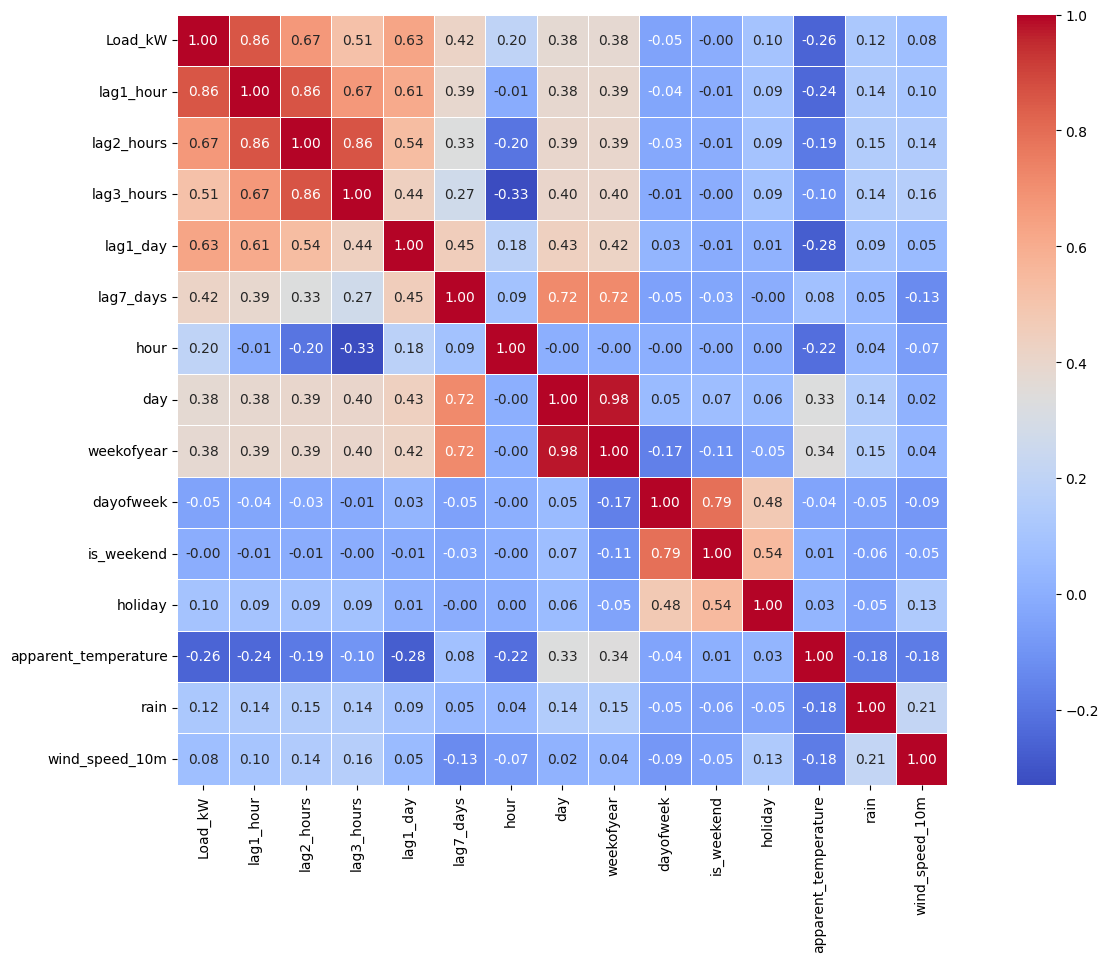

,Load_kW,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,hour,day,weekofyear,dayofweek,is_weekend,holiday,apparent_temperature,rain,wind_speed_10m
0,0.8709,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,27,0,0,0,30.4000,3.9000,9.8000
1,0.8313,0.8709,0.0000,0.0000,0.0000,0.0000,1,1,27,0,0,0,34.9000,0.0000,2.3000
2,0.7231,0.8313,0.8709,0.0000,0.0000,0.0000,2,1,27,0,0,0,35.0000,0.0000,6.4000
3,0.6937,0.7231,0.8313,0.8709,0.0000,0.0000,3,1,27,0,0,0,35.7000,0.0000,8.4000
4,0.6398,0.6937,0.7231,0.8313,0.0000,0.0000,4,1,27,0,0,0,37.1000,0.0000,8.2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,0.6751,0.7670,0.7677,0.8446,0.9444,0.6452,19,31,31,2,0,0,31.3000,25.1000,19.3000
740,0.7478,0.6751,0.7670,0.7677,1.0124,0.7761,20,31,31,2,0,0,32.7000,15.3000,10.8000
741,0.7547,0.7478,0.6751,0.7670,1.1667,0.8738,21,31,31,2,0,0,33.3000,6.0000,7.8000
742,0.8495,0.7547,0.7478,0.6751,1.2193,0.9304,22,31,31,2,0,0,32.6000,3.9000,11.2000


In [5]:
testing_obj = testing()

latitude, longitude = "28.625361","77.376214"#, 28.628059,77.378912
from_date = resample_df.first_valid_index().date()
to_date = resample_df.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)
weather_df = npcl_obj.weather_data_api(latitude,longitude,from_date,to_date,duration="15min")

holidays_lst= common_obj.holidays_list(from_date,to_date)
print("holidays_lst:",holidays_lst)
df_lags = testing_obj.add_lags(resample_df,target_col="Load_kW")
df_features = testing_obj.create_features(df_lags)


for date in holidays_lst:
    df_features.loc[f"{date}", 'holiday'] = 1
final_df = df_features.merge(weather_df,on=["creation_time"])
final_df.drop(['creation_time'],axis=1,inplace=True)
final_df.fillna(0,inplace= True)
# final_df.dropna(inplace=True)
common_obj.correlation_matrix(final_df)
final_df

In [7]:
train_dataset.columns

,Load_kW,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,hour,day,weekofyear,dayofweek,is_weekend,holiday,apparent_temperature,rain,wind_speed_10m
0,0.8709,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,27,0,0,0,30.4000,3.9000,9.8000
1,0.8313,0.8709,0.0000,0.0000,0.0000,0.0000,1,1,27,0,0,0,34.9000,0.0000,2.3000
2,0.7231,0.8313,0.8709,0.0000,0.0000,0.0000,2,1,27,0,0,0,35.0000,0.0000,6.4000
3,0.6937,0.7231,0.8313,0.8709,0.0000,0.0000,3,1,27,0,0,0,35.7000,0.0000,8.4000
4,0.6398,0.6937,0.7231,0.8313,0.0000,0.0000,4,1,27,0,0,0,37.1000,0.0000,8.2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,0.7930,0.8670,0.8645,0.8606,0.7280,0.8627,16,28,30,6,1,1,37.4000,0.0000,6.9000
665,0.6823,0.7930,0.8670,0.8645,0.6704,0.7001,17,28,30,6,1,1,36.8000,0.0000,7.4000
666,0.6372,0.6823,0.7930,0.8670,0.6007,0.6581,18,28,30,6,1,1,36.1000,0.0000,8.6000
667,0.6961,0.6372,0.6823,0.7930,0.6520,0.6749,19,28,30,6,1,1,35.7000,0.0000,8.0000


In [6]:
# testing.data_split(final_df)
train_dataset,test_dataset = testing_obj.data_split_function(dataset=final_df)
print(train_dataset.shape,test_dataset.shape)

(669, 15) (75, 15)


In [27]:
def scaling_layer(dataset,target_variable= "Load_kW"):
    scaler = MinMaxScaler()
    # Exclude the "Load_kW" column from features to normalize
    features_to_normalize = [col for col in dataset.columns if col != target_variable]
    dataset[features_to_normalize] = scaler.fit_transform(dataset[features_to_normalize])
    with open('saved_model/minmax_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    return dataset,scaler


def data_split(dataset, target_variable= "Load_kW"): 
    try:
        dataset_features = dataset.copy()
        dataset_label = dataset_features.pop(target_variable)
        # Split the dataset into training and test sets
        train_features, test_features, train_labels, test_labels= train_test_split(dataset_features, dataset_label, test_size=0.1, 
                                                            random_state=42
                                                            )
        logger.info(f"data split done")
        logger.info(f"train_features shape:{train_features.shape} ,train_label shape: {train_labels.shape}")
        logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
        return train_features, test_features, train_labels, test_labels

    except Exception as e:
        logger.error(f"error in data split: {e}",exc_info=True)

# # Scaling the data using MinMaxScaler
dataset_scaled,scalerrr = scaling_layer(train_dataset)

train_features, test_features, train_label, test_label = data_split(dataset_scaled)


# # Reshaping data for LSTM (LSTM requires 3D shape: [samples, time_steps, features])
train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))
print(train_features.shape)
print(test_features.shape)

# Build LSTM model
model = Sequential()

# Adding LSTM layers
model.add(LSTM(units=64, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))  # Prevent overfitting
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

# # Adding dense output layer
model.add(Dense(units=1))  # Predicting the target variable

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model.fit(train_features, train_label, epochs=50, batch_size=64, validation_data=(test_features, test_label))

# # Save the model to a file
# model_version = max([int(i.split(".")[1]) for i in os.listdir("saved_model/test") if i.split(".")[1].isdigit()]) + 1
# history.save(f"saved_model/test/lstm_model_{model_version}.h5")

# # Prediction and evaluation
# self.prediction(model=history, input_data=test_features, scoring=True, test_data=test_label)


AttributeError: Can't pickle local object 'PreprocessingLayer.make_adapt_function.<locals>.adapt_step'

In [7]:
# Normalization using TensorFlow instead of MinMaxScaler
def scaling_layer(dataset, target_variable="Load_kW"):
    try:
        # Separate the target variable from the features
        dataset_features = dataset.copy()
        dataset_labels = dataset_features.pop(target_variable)

        # Create a Normalization layer
        normalizer = tf.keras.layers.Normalization(axis=-1)

        # Adapt the normalizer to the features (computes mean and variance)
        normalizer.adapt(dataset_features)

        # Normalize the dataset
        normalized_dataset = normalizer(dataset_features)

        # Convert back to dataframe format (optional, based on your use case)
        normalized_dataset = np.array(normalized_dataset)

        # Save the normalization layer
        os.makedirs('saved_model', exist_ok=True)
        normalizer.save('saved_model/tf_normalizer')

        return normalized_dataset, dataset_labels, normalizer
    except Exception as e:
        logger.error(f"Error in scaling layer: {e}", exc_info=True)

# Data splitting using TensorFlow
def data_split(dataset, dataset_labels, test_size=0.1):
    try:
        # Calculate split index
        total_size = len(dataset)
        split_index = int(total_size * (1 - test_size))

        # Split into training and test sets
        train_features = dataset[:split_index]
        test_features = dataset[split_index:]
        train_labels = dataset_labels[:split_index]
        test_labels = dataset_labels[split_index:]

        logger.info(f"Data split done")
        logger.info(f"train_features shape: {train_features.shape}, train_labels shape: {train_labels.shape}")
        logger.info(f"test_features shape: {test_features.shape}, test_labels shape: {test_labels.shape}")
        return train_features, test_features, train_labels, test_labels
    except Exception as e:
        logger.error(f"Error in data split: {e}", exc_info=True)

# Scaling the data using TensorFlow's Normalization layer
train_features, train_labels, normalizer = scaling_layer(train_dataset)

# Splitting the data into training and test sets
train_features, test_features, train_labels, test_labels = data_split(train_features, train_labels)

# Reshaping data for LSTM (3D shape: [samples, time_steps, features])
train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))
print(train_features.shape)
print(test_features.shape)

# Building the LSTM model
model = Sequential()

# Adding LSTM layers
model.add(LSTM(units=64, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(Dropout(0.2))  # Prevent overfitting
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

# Adding a dense output layer
model.add(Dense(units=1))  # Predicting the target variable

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(train_features, train_labels, epochs=50, batch_size=64, validation_data=(test_features, test_labels))

# # Save the model
# model_version = max([int(i.split(".")[1]) for i in os.listdir("saved_model/test") if i.split(".")[1].isdigit()] or [0]) + 1
# model.save(f"saved_model/test/lstm_model_{model_version}.h5")

# Prediction and evaluation
# You can now use model.evaluate() and model.predict() functions to evaluate or make predictions.


TypeError: cannot unpack non-iterable NoneType object

In [23]:
def plot_prediction(actual, predicted):
    rmse = sqrt(mean_squared_error(actual, predicted))
    print("\nModel Power Evaluation")
    print("Mean Squared Error (MSE):", mean_squared_error(actual, predicted))
    print("Mean Absolute Error (MAE):", mean_absolute_error(actual, predicted))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("R-squared:", r2_score(actual, predicted))

    # Scatter plot
    plt.figure(figsize=(10, 6))
    # Plot actual values in red
    plt.plot(range(len(actual)), actual, color='red', label='Actual Power')
    # Plot predicted values in blue
    plt.plot(range(len(predicted)), predicted, color='blue', label='Predicted Power')
    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('load')
    plt.title('Actual vs Predicted load')
    plt.legend()
    plt.tight_layout()
    plt.show()


3/3 [==============================] - 1s 2ms/step

Model Power Evaluation
Mean Squared Error (MSE): 0.004038546878388762
Mean Absolute Error (MAE): 0.04624162482898846
Root Mean Squared Error (RMSE): 0.06354956237763375
R-squared: 0.8670149406242611


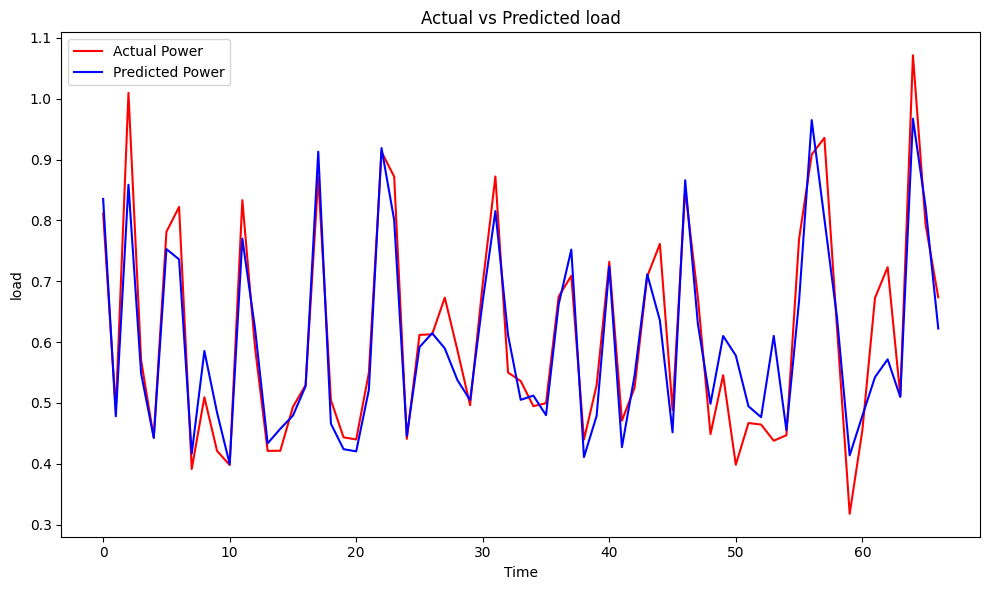

In [24]:
pred = model.predict(test_features)
plot_prediction(test_label,pred)

In [25]:
testing_features = test_dataset.copy()
testing_label = testing_features.pop('Load_kW')

3/3 [==============================] - 0s 2ms/step

Model Power Evaluation
Mean Squared Error (MSE): 0.7943635632311563
Mean Absolute Error (MAE): 0.8679641493068873
Root Mean Squared Error (RMSE): 0.8912707575317146
R-squared: -166.1250595093403


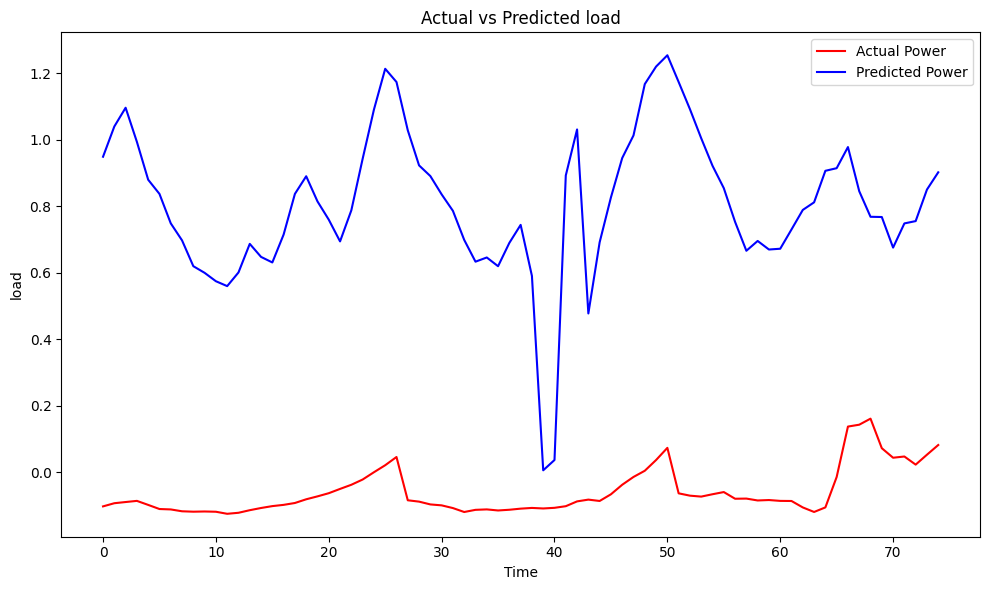

In [26]:

# with open('saved_model/minmax_scaler.pkl', 'rb') as f:
#     scaler = pickle.load(f)
scaled_input = scalerrr.transform(testing_features)
# train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
scaled_input = np.array(scaled_input).reshape((scaled_input.shape[0], 1, scaled_input.shape[1]))
pred = model.predict(scaled_input)
plot_prediction(actual=pred, predicted=testing_label)



In [ ]:
# def prediction(model, input_data, scoring=False, test_data= None,prediction= False):
#     try:
# if prediction:
#     # scaler= scaler_value()

#     input_data = scaler.transform(input_data)

# Step 6: Make predictions
values = 200
y_pred = model.predict(test_features)
if y_pred is not None:
    logger.info("predition_succesful")

actual = test_label[0:values]
predicted = y_pred[0:values]

